In [11]:
%load_ext lab_black

# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [203]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    make_scorer,
    accuracy_score,
    RocCurveDisplay,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import mode
from pathlib import Path
import pandas as pd

# Задание 1 (3 балла)

Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [363]:
class RandomForestClassifier:
    def __init__(
        self,
        criterion="gini",
        max_depth=None,
        min_samples_leaf=1,
        max_features="auto",
        n_estimators=10,
        save_samples_idx=False,
    ):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self._trees = None
        self._features = None
        self._save_samples_idx = save_samples_idx

    def fit(self, X, y):
        m, n = X.shape
        if self.max_features == "auto":
            self.max_features_n = int(np.sqrt(n))
        self._trees = []
        self._features = []
        self._samples_idx = []
        all_features = np.arange(n)
        all_samples = np.arange(m)
        for i in range(self.n_estimators):
            tree = DecisionTreeClassifier(
                criterion=self.criterion,
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
            )
            tree_features = np.random.choice(
                all_features, size=self.max_features_n, replace=False
            )
            samples_idx = np.random.choice(all_samples, size=m, replace=True)
            if self._save_samples_idx:
                self._samples_idx.append(samples_idx)
            X_tree = X[samples_idx][:, tree_features]
            y_tree = y[samples_idx]
            tree.fit(X_tree, y_tree)
            self._trees.append(tree)
            self._features.append(tree_features)

    def predict(self, X):
        # only binary
        predictions = []
        for tree, features in zip(self._trees, self._features):
            X_tree = X[:, features]
            preds = tree.predict(X_tree)
            predictions.append(preds)
        predictions = np.stack(predictions)
        return predictions.sum(axis=0) / predictions.shape[0]

    def predict_nonbinary(self, X):
        predictions = []
        for tree, features in zip(self._trees, self._features):
            X_tree = X[:, features]
            preds = tree.predict(X_tree)
            predictions.append(preds)
        predictions = np.stack(predictions)
        return mode(predictions, axis=0)[0]

    def get_params(self, deep=True):
        return {
            "criterion": self.criterion,
            "max_depth": self.max_depth,
            "min_samples_leaf": self.min_samples_leaf,
            "max_features": self.max_features,
            "n_estimators": self.n_estimators,
        }

    def set_params(self, **params):
        return self.__class__(**params)

## Load dataset

In [355]:
DATA_PATH = Path("./homework-ensembles-ib-22/")

In [356]:
def load_train_dataset(DATA_PATH=DATA_PATH):
    df_train = pd.read_csv(Path(DATA_PATH) / "x_spam_train.csv")
    df_train = df_train.drop(columns=["Id"])
    df_test = pd.read_csv(Path(DATA_PATH) / "y_spam_train.csv")
    df_test = df_test.drop(columns=["Id"])
    return df_train.values, df_test.values.reshape(df_train.values.shape[0])

In [357]:
def load_test_dataset(DATA_PATH=DATA_PATH):
    df_train = pd.read_csv(Path(DATA_PATH) / "x_spam_test.csv")
    df_train = df_train.drop(columns=["Id"])
    return df_train.values

In [358]:
X_train, y_train = load_train_dataset()
X_test = load_test_dataset()

## Test

In [359]:
test_classifier = RandomForestClassifier()
test_classifier.fit(X_train, y_train)
preds = test_classifier.predict(X_train)
roc_auc_score(y_train, preds)

0.9943739310468991

видно, что переобучение есть, значит как-то работает

# Задание 2 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [231]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.2
)

In [232]:
param_grid = {"max_depth": [2, 3, 5, 7, 10], "n_estimators": [5, 10, 20, 30, 50, 100]}

In [233]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_gird,
    scoring=roc_auc_scorer,
    cv=5,
    verbose=3,
)

In [234]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .......max_depth=2, n_estimators=5;, score=0.867 total time=   0.0s
[CV 2/5] END .......max_depth=2, n_estimators=5;, score=0.922 total time=   0.0s
[CV 3/5] END .......max_depth=2, n_estimators=5;, score=0.920 total time=   0.0s
[CV 4/5] END .......max_depth=2, n_estimators=5;, score=0.914 total time=   0.0s
[CV 5/5] END .......max_depth=2, n_estimators=5;, score=0.925 total time=   0.0s
[CV 1/5] END ......max_depth=2, n_estimators=10;, score=0.903 total time=   0.0s
[CV 2/5] END ......max_depth=2, n_estimators=10;, score=0.917 total time=   0.1s
[CV 3/5] END ......max_depth=2, n_estimators=10;, score=0.912 total time=   0.1s
[CV 4/5] END ......max_depth=2, n_estimators=10;, score=0.933 total time=   0.0s
[CV 5/5] END ......max_depth=2, n_estimators=10;, score=0.905 total time=   0.0s
[CV 1/5] END ......max_depth=2, n_estimators=20;, score=0.946 total time=   0.1s
[CV 2/5] END ......max_depth=2, n_estimators=20

GridSearchCV(cv=5,
             estimator=<__main__.RandomForestClassifier object at 0x7f9aa76810d0>,
             param_grid={'max_depth': [2, 3, 5, 7, 10],
                         'n_estimators': [5, 10, 20, 30, 50, 100]},
             scoring=make_scorer(roc_auc_score), verbose=3)

In [235]:
best_params = grid_search.best_params_

In [236]:
print(f"Лучшие параметры: {best_params}, c AUC на CV: {grid_search.best_score_:.2f}")

Лучшие параметры: {'max_depth': 10, 'n_estimators': 100}, c AUC на CV: 0.96


In [237]:
val_classifier = RandomForestClassifier(**best_params)
val_classifier.fit(X_train_train, y_train_train)
y_val_pred = val_classifier.predict(X_train_val)

In [238]:
print(
    f"Scores on validation:\nAUC: {roc_auc_score(y_train_val, y_val_pred):.2f},\nAccuracy: {accuracy_score(y_train_val,(y_val_pred>0.5).astype(int)):.2f},\nF1:{f1_score(y_train_val,(y_val_pred>0.5).astype(int)):.2f}"
)

Scores on validation:
AUC: 0.96,
Accuracy: 0.88,
F1:0.82


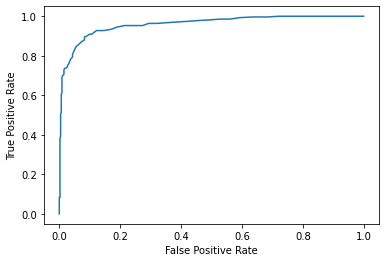

In [243]:
fpr, tpr, _ = roc_curve(y_train_val, y_val_pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [366]:
final_classifier = RandomForestClassifier(**best_params)
final_classifier.fit(X_train, y_train)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [367]:
y_test_preds = (final_classifier.predict(X_test) > 0.5).astype(int)
df = pd.DataFrame(
    {"Expected": y_test_preds, "Id": np.arange(y_test_preds.shape[0])},
)
df.to_csv("submission.csv", index=False)

# Задание 3 (3 балла)

Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [302]:
final_classifier = RandomForestClassifier(**best_params, save_samples_idx=True)
final_classifier.fit(X_train, y_train)

In [410]:
def compute_oob(rfc, X, y):
    oob = []
    for tree, features, samples_idx in zip(
        rfc._trees,
        rfc._features,
        rfc._samples_idx,
    ):
        oob_samples_idx = np.array(
            list(set(np.arange(X.shape[0])) - set(samples_idx)), dtype=int
        )
        oob_X = X[oob_samples_idx][:, features]
        oob_y = y[oob_samples_idx]
        oob_y_pred = tree.predict(oob_X)
        oob_f1 = accuracy_score(oob_y, oob_y_pred)
        oob.append(oob_f1)
    return np.array(oob)

In [411]:
def feature_importance(rfc, X, y):
    m, n = X.shape
    impor = []
    oob_error = compute_oob(rfc, X, y)
    for i in range(X.shape[1]):
        X_j = np.copy(X)
        X_j[:, i] = np.random.choice(X_j[:, i], size=m, replace=False)
        oob_error_j = compute_oob(rfc, X_j, y)
        impor.append((oob_error - oob_error_j).mean())
    return impor


def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [419]:
def synthetic_dataset(size):
    X = [
        (
            np.random.randint(0, 2),
            np.random.randint(0, 2),
            i % 6 == 3,
            i % 6 == 0,
            i % 3 == 2,
            np.random.randint(0, 2),
        )
        for i in range(size)
    ]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)


X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100, save_samples_idx=True)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict_nonbinary(X)[0] == y))
print("Importance:", feature_importance(rfc, X, y))

Accuracy: 0.983
Importance: [-0.002088211969101795, 0.002192018062102105, 0.06190600904302892, 0.050579435965379345, 0.1195923745841803, 0.0015455361073504182]


Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

In [424]:
rfc = RandomForestClassifier(**best_params, save_samples_idx=True)
rfc.fit(X_train_train, y_train_train)
print("Accuracy:", np.mean(rfc.predict_nonbinary(X_train_train)[0] == y_train_train))
impor = feature_importance(rfc, X_train_train, y_train_train)
print("Importance:", impor)
print(
    "Most important: ",
    most_important_features(impor, names=np.arange(X_train_train.shape[1])),
)

Accuracy: 0.9110054347826086
Importance: [0.001755475508325648, 0.004649535242677524, 0.007785177165932455, 0.0005508902617626222, 0.011113835739528656, 0.004973873569889704, 0.009408574028220908, 0.0021261822041550803, 0.003784949729887109, 0.007715630911304466, 0.004754894048823713, 0.003992866321290847, 0.0021255643260307223, 0.0006383360614456424, 0.0021832741218030527, 0.014973629814533483, 0.006281655547978017, 0.004833960594130538, 0.009173230936030036, 0.004792810126322862, 0.0162413761535787, 0.0006184476631308633, 0.004952908037770852, 0.010927855819060582, 0.008723726229129121, 0.0052218913440734895, 0.004279456493132803, 0.0018919344474636502, 0.002788622399582723, 0.0031710703249501126, 0.0026351364016855227, 0.0007325762399844626, 0.0009797410082995717, 0.0005506266260826986, 0.0022604708474010414, 0.0011807899411748846, 0.004653295651141968, 1.8121559651843587e-05, 0.001583038420133749, 0.0014386884314764037, 0.00038600371005816705, 0.0014908240771925984, 0.0018858859349

# Задание 4 (2 балла)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [265]:
import xgboost as xg
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [253]:
%%timeit
xg_classifier = xg.XGBClassifier()
xg_classifier.fit(X_train_train, y_train_train)

[23:02:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [281]:
xg_classifier = xg.XGBClassifier()
xg_classifier.fit(X_train_train, y_train_train)
y_val_pred_xg = xg_classifier.predict_proba(
    X_train_val,
)
print("Xgboost".center(30, "-"))
print(
    f"Scores on validation:\nAUC: {roc_auc_score(y_train_val, y_val_pred_xg[:,1]):.3f},\nAccuracy: {accuracy_score(y_train_val,y_val_pred_xg.argmax(axis=1)):.3f},\nF1:{f1_score(y_train_val,y_val_pred_xg.argmax(axis=1)):.3f}"
)

/home/stepan/miniconda3/envs/scientific/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------Xgboost------------
Scores on validation:
AUC: 0.979,
Accuracy: 0.951,
F1:0.935


In [267]:
%%timeit
cb_classifier = CatBoostClassifier(silent=True)
cb_classifier.fit(X_train_train,y_train_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

6.51 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [282]:
cb_classifier = CatBoostClassifier(silent=True)
cb_classifier.fit(X_train_train, y_train_train)
y_val_pred_cb = cb_classifier.predict_proba(
    X_train_val,
)
print("CatBoost".center(30, "-"))
print(
    f"Scores on validation:\nAUC: {roc_auc_score(y_train_val, y_val_pred_cb[:,1]):.3f},\nAccuracy: {accuracy_score(y_train_val,y_val_pred_cb.argmax(axis=1)):.3f},\nF1:{f1_score(y_train_val,y_val_pred_cb.argmax(axis=1)):.3f}"
)

-----------CatBoost-----------
Scores on validation:
AUC: 0.980,
Accuracy: 0.946,
F1:0.927


_Ваш ответ_

In [292]:
lg_classifier = LGBMClassifier()
lg_classifier.fit(X_train_train, y_train_train)
y_val_pred_lg = lg_classifier.predict_proba(
    X_train_val,
)
print("CatBoost".center(30, "-"))
print(
    f"Scores on validation:\nAUC: {roc_auc_score(y_train_val, y_val_pred_lg[:,1]):.3f},\nAccuracy: {accuracy_score(y_train_val,y_val_pred_lg.argmax(axis=1)):.3f},\nF1:{f1_score(y_train_val,y_val_pred_lg.argmax(axis=1)):.3f}"
)

-----------CatBoost-----------
Scores on validation:
AUC: 0.981,
Accuracy: 0.951,
F1:0.935


In [293]:
%%timeit
lg_classifier = LGBMClassifier()
lg_classifier.fit(X_train_train, y_train_train)

542 ms ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Выводы: библиотечные реализации бустингов с стандартными параметрами дают очень похожее качество и лучше, чем случаный лес(возможно параметры подобраны не лучшие). LGBM быстрее всех, xgboost на втором месте. Однако есть реализации обучения на GPU - там возможен другой порядок. Между этими тремя пакетами я бы выбирал, исходя из из остальных фич: из опыта, catboost хорошо работает с категоральными признакаим.